# <font color='red'>SGD Algorithm to predict movie ratings</font>

## <font color='red'>Task 1</font>

Predicted rating $\hat{y}_{ij}$ for user i, movied j pair is calcuated as $\hat{y}_{ij} = \mu + b_i + c_j + u_i^T v_j$ , here we will be finding the best values of $b_{i}$ and $c_{j}$ using SGD algorithm with the optimization problem for N users and M movies is defined as

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>

 $ \ $


<br>

<font color='red'> Reading the csv file </font>

In [ ]:
import pandas as pd
data=pd.read_csv('ratings_train.csv')
print(data.shape)
data.head()

(89992, 3)


,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


In [ ]:
data["user_id"].max(),data["user_id"].min()

(942, 0)

In [ ]:
data["item_id"].max(),data["item_id"].min()

(1680, 0)

<font color='red'>Create your adjacency matrix </font>

In [ ]:
from scipy.sparse import csr_matrix
import numpy as np


In [ ]:
row = np.array(data.user_id.values)
col = np.array(data.item_id.values)
dat = np.array(data["rating"])
adjacency_matrix=csr_matrix((dat, (row, col)), shape=(943, 1681)).toarray()

In [ ]:
adjacency_matrix.shape

(943, 1681)

<font color='red'> SVD decompostion</font>

Sample code for SVD decompostion

In [ ]:
from sklearn.utils.extmath import randomized_svd
import numpy as np 

U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=2,n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 2)
(2,)
(1681, 2)


<font color='red'>Compute mean of ratings</font>

In [ ]:
def m_u(ratings):
  
    return ratings.mean()

In [ ]:
mu=m_u(data['rating'])
print(mu)

3.529480398257623


<font color='red'>Initialize $B_{i}$ and $C_{j}$

In [ ]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    # initalize the value to zeros 
    # return output as a list of zeros 

    

    return np.zeros((dim,))

In [ ]:
dim=adjacency_matrix.shape[0] # give the number of dimensions for b_i (Here b_i corresponds to users)
b_i=initialize(dim)
dim=adjacency_matrix.shape[1] # give the number of dimensions for c_j (Here c_j corresponds to movies)
c_j=initialize(dim)

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<font color='red'>Compute dL/db_i</font>

In [ ]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    db=2*(b_i[user_id]*(alpha+1)-rating+mu+c_j[item_id]+np.dot(U[user_id],V.T[item_id]))
    #print(db)
    return db


<font color='red'>Compute dL/dc_j</font>

In [ ]:
def derivative_dc(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/dc_j'''
    dc=2*(c_j[item_id]*(alpha+1)-rating+mu+b_i[user_id]+np.dot(U[user_id],V.T[item_id]))
#    print(dc)
    #print(c_j[item_id])
    #s=np.sum(dc,axis=0)
    #print(np.sum(s))
    
    return dc


<font color='red'>Compute MSE (mean squared error) for predicted ratings</font>


In [ ]:
from sklearn.utils import shuffle
mse=[]
lr=0.1
for epoch in range(0,6):
  ypred=np.zeros((943,1681))
  data=shuffle(data)

  row = np.array(data.user_id.values)
  col = np.array(data.item_id.values)
  dat = np.array(data["rating"])
  adjacency_matrix=csr_matrix((dat, (row, col)), shape=(943, 1681)).toarray()
  U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=1681,n_iter=5, random_state=None)
  

  
  ratings=data["rating"]
  mu=m_u(ratings)
  for i in range(0,len(adjacency_matrix)):
    for  j in range(0,len(adjacency_matrix.T)):
      b_i=b_i-lr*derivative_db(i,j,adjacency_matrix[i][j],U,VT,mu,0.01)
      
      c_j=c_j-lr*derivative_dc(i,j,adjacency_matrix[i][j],U,VT,mu,0.01)
      
  
      ypred[i][j]=mu+b_i[i]+c_j[j]+np.dot(U[i],VT[:,j])
  err_mat=adjacency_matrix-ypred
  sqr=(np.sum(np.sum(np.dot(err_mat,err_mat.T),axis=0)))/(adjacency_matrix.shape[0]*adjacency_matrix.shape[1])
  mse.append(sqr)

<font color='red'>Plot epoch number vs MSE </font>

* epoch number on X-axis
* MSE on Y-axis

In [ ]:
mse

[21.285579354758344,
 21.288016428134743,
 21.28801642813474,
 21.288016428134743,
 21.288016428134743,
 21.288016428134743]

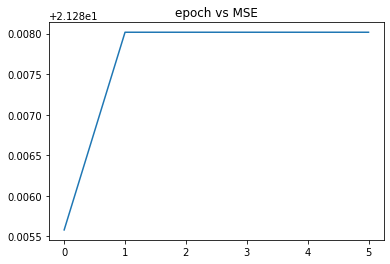

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0,6),mse)
plt.title("epoch vs MSE")
plt.show()
